In [1]:
%matplotlib inline
import numpy as np
import numpy.linalg as la
from __future__ import division
import matplotlib.pyplot as plt

# Constants

In [2]:
sigma_tr = 3.62e-2
nusig = 0.1570
sigma_a = 0.1532
d = 1. / (3. * sigma_tr)

In [3]:
nodes = 10.
width = 10.

In [4]:
np.ones(5)

array([ 1.,  1.,  1.,  1.,  1.])

In [5]:
dx = (width / (nodes - 1)) ** 2
np.ones(5) * (sigma_a + 2. * d / dx ** 2)

array([ 12.23607293,  12.23607293,  12.23607293,  12.23607293,  12.23607293])

# Matrix Setter

In [6]:
def matrix(nodes, width, absorption=0.1532, transfer=3.62e-2):
    sections = nodes - 1
    dx = width / sections
    
    diffusion = 1. / (3. * transfer)
    
    diag_val = (absorption + 2. * diffusion / dx ** 2)
    offdiag_val = (- diffusion / dx ** 2)
    
    diag = np.ones(sections) * diag_val
    offdiag = np.ones(sections - 1) * offdiag_val
    
    mat = np.diag(diag, 0) + np.diag(offdiag, -1) + np.diag(offdiag, 1)
    mat[0,0] = 0.5 * diag_val
    
    return mat

In [7]:
matrix(6, 154)

array([[ 0.08630664, -0.00970664,  0.        ,  0.        ,  0.        ],
       [-0.00970664,  0.17261327, -0.00970664,  0.        ,  0.        ],
       [ 0.        , -0.00970664,  0.17261327, -0.00970664,  0.        ],
       [ 0.        ,  0.        , -0.00970664,  0.17261327, -0.00970664],
       [ 0.        ,  0.        ,  0.        , -0.00970664,  0.17261327]])

# Flux and k eigenvector/eigenvalue solver

Solve for eigenvalue (flux) and eigenvector of the matrix using [Power iteration](https://en.wikipedia.org/wiki/Power_iteration) method

In [19]:
def power(nodes, width, nusig=0.1570, absorption=0.1532, transfer=3.62e-2, min_error=0.00001, max_iterations=1e5):
    flux = np.ones(nodes-1) * 100.
    k_eff = 1.0
    flux_old = np.ones(nodes-1) * 100.
    k_eff_old = 1.0
    
    flux_error = 1.0
    k_eff_error = 1.0
    
    iterations = 0
    
    source = np.ones_like(flux) * nusig
    source[0] = source[0] * 0.5
    
    mat = matrix(nodes, width, absorption, transfer)
    
    while ((flux_error > min_error) or (k_eff_error > min_error)) and (iterations < max_iterations):
        # iterate generations
        iterations += 1
        
        flux = la.solve(mat, np.multiply(flux, source) / k_eff)
        
        # solve for eigenvalue
        k_eff = k_eff_old * la.norm(np.multiply(flux, source)) / la.norm(np.multiply(flux_old, source))
        
        flux = flux / la.norm(flux)
        
        flux_error = np.amax(abs((np.multiply(flux, source) - np.multiply(flux_old, source)) / np.multiply(flux, source)))
        k_eff_error = (abs((k_eff - k_eff_old) / k_eff))
        
        k_eff_old = k_eff
        flux_old = flux
        
        if (iterations % 10000 == 0):
            print flux_error
    
    return flux, k_eff, flux_error, k_eff_error, iterations

# Critical Width Search

Calculated as $$ \tilde{a} = \pi \sqrt{ \frac{D}{\nu \Sigma_f - \Sigma_a} } $$

In [9]:
analytic_critical_width = np.pi * (d / (nusig - sigma_a)) ** 0.5
analytic_critical_width

154.64759189932184

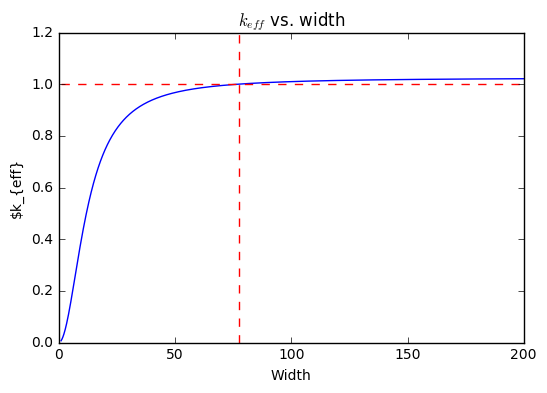

In [12]:
w = np.linspace(1., 200., 1000.)
plt.plot(w, [power(10, x)[1] for x in w])
plt.plot(w, [1. for x in w], 'r--')
# plt.xscale("log")
plt.axvline(analytic_critical_width / 2, color='r', linestyle='--')
plt.title(r'$k_{eff}$ vs. width')
plt.ylabel(r'$k_{eff}')
plt.xlabel('Width')
plt.savefig('images/k_eff_vs_width.png', dpi=1000)
plt.show()

In [116]:
def critical_width(nodes, width):
    return True

# Flux vs number of nodes

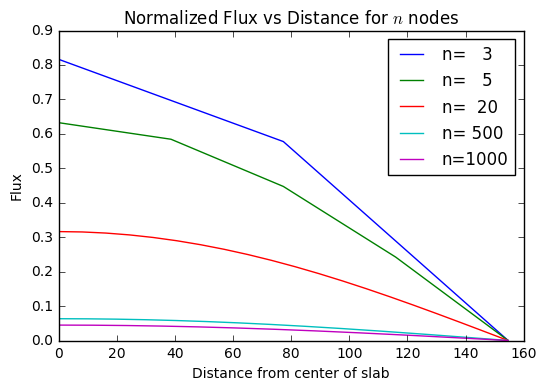

In [22]:
for nodes in [3, 5, 20, 500, 1000]:
    x = np.linspace(0, analytic_critical_width, nodes)
    flux = np.append(power(nodes, analytic_critical_width)[0], 0)
    plt.plot(x, flux, label='n={0:4g}'.format(nodes))
plt.legend(loc='upper right')
plt.xlabel('Distance from center of slab')
plt.ylabel('Flux')
plt.title('Normalized Flux vs Distance for $n$ nodes')
plt.savefig('images/flux_vs_nodes', dpi=1000)
plt.show()